# Explore here

In [1]:
# Yoimport numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from pickle import dump
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'

data = pd.read_csv(url, delimiter=',')
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [3]:
X = data.drop(["Outcome"], axis=1)
y = data["Outcome"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


parametros = {
    "n_estimators" : [100, 200, 300],
    "learning_rate" : [0.01, 0.1, 0.2],
    "subsample" : [0.7, 0.8, 0.9, 1],
    "max_depth" : [3, 4, 5],
    "gamma" : [0, 1, 3],
    "min_child_weight" : [1, 3, 5],
    "colsample_bytree" : [0.6, 0.8, 1.0],
    "colsample_bylevel" : [0.6, 0.8, 1.0]
}


modelo_boost = XGBClassifier(n_estimators = 200, learning_rate = 0.001, random_state = 42)
RS = RandomizedSearchCV(modelo_boost, parametros, n_iter=10, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
RS.fit(X_train, y_train)

modelo_RS = RS.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [5]:
modelo_rf = joblib.load('../models/randomforest.sav')

pred_rf = modelo_rf.predict(X_test)
pred_boost = modelo_RS.predict(X_test)

print("=== Random Forest ===")
print("Accuracy Random Forest:", accuracy_score(y_test, pred_rf))
print("F1 Score:", f1_score(y_test, pred_rf))
print("Matriz de confusion:")
print(confusion_matrix(y_test, pred_rf))

print("\n=== Boosting ===")
print("Accuracy Boosting:", accuracy_score(y_test, pred_boost))
print("F1 Score:", f1_score(y_test, pred_boost))
print("Matriz de confusion:")
print(confusion_matrix(y_test, pred_boost))

=== Random Forest ===
Accuracy Random Forest: 0.7467532467532467
F1 Score: 0.6608695652173913
Matriz de confusion:
[[77 22]
 [17 38]]

=== Boosting ===
Accuracy Boosting: 0.7532467532467533
F1 Score: 0.6666666666666666
Matriz de confusion:
[[78 21]
 [17 38]]


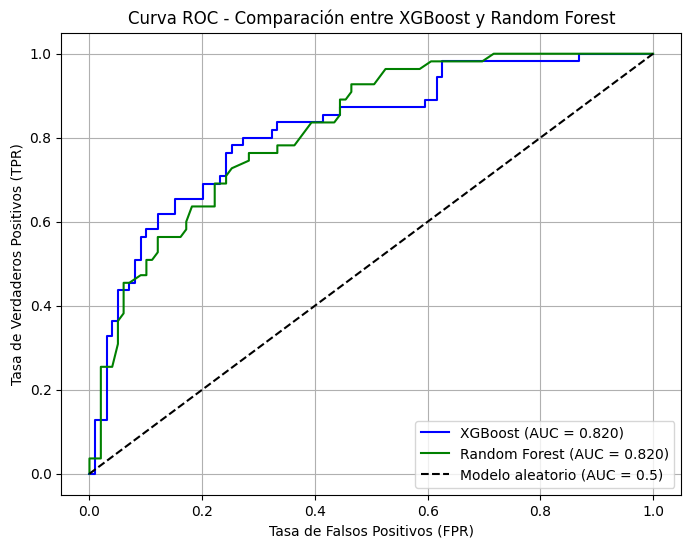

In [6]:

probabilidades_boost = modelo_RS.predict_proba(X_test)[:, 1]
probabilidades_rf = modelo_rf.predict_proba(X_test)[:, 1]


f_positivos_boost, v_positivos_boost, _ = roc_curve(y_test, probabilidades_boost)
f_positivos_rf, v_positivos_rf, _ = roc_curve(y_test, probabilidades_rf)


auc_boost = roc_auc_score(y_test, probabilidades_boost)
auc_rf = roc_auc_score(y_test, probabilidades_rf)

# Gráfico ROC comparativo
plt.figure(figsize=(8, 6))
plt.plot(f_positivos_boost, v_positivos_boost, label=f"XGBoost (AUC = {auc_boost:.3f})", color='blue')
plt.plot(f_positivos_rf, v_positivos_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Modelo aleatorio (AUC = 0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Comparación entre XGBoost y Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [7]:
dump(modelo_RS, open("boosting.sav", "wb"))